In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [11]:
# Định nghĩa mã cổ phiếu và khoảng thời gian lấy dữ liệu
ma_cophieu = "BSI.VN"
khoang_thoi_gian = "60d"  # Lấy dữ liệu trong 60 ngày gần nhất
buoc_thoi_gian = "5m"     # Khoảng thời gian 5 phút

# Tải dữ liệu từ Yahoo Finance
data = yf.download(ma_cophieu, period=khoang_thoi_gian, interval=buoc_thoi_gian)

# Kiểm tra dữ liệu
print(data.head())


[*********************100%***********************]  1 of 1 completed

Price                        Close     High      Low     Open Volume
Ticker                      BSI.VN   BSI.VN   BSI.VN   BSI.VN BSI.VN
Datetime                                                            
2025-01-06 02:15:00+00:00  46600.0  46600.0  46600.0  46600.0      0
2025-01-06 02:25:00+00:00  46650.0  47100.0  46600.0  47100.0   6500
2025-01-06 02:30:00+00:00  47000.0  47000.0  46700.0  46700.0    200
2025-01-06 02:35:00+00:00  46800.0  46800.0  46800.0  46800.0   1600
2025-01-06 02:45:00+00:00  46800.0  46800.0  46800.0  46800.0   1800


In [13]:
# Lựa chọn cột giá đóng cửa và loại bỏ các giá trị NaN
data = data[['Close']].dropna()

# Chuẩn hóa dữ liệu về khoảng [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Chia dữ liệu thành tập huấn luyện và kiểm tra (80% huấn luyện, 20% kiểm tra)
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Hàm tạo tập dữ liệu theo định dạng phù hợp cho LSTM
def create_dataset(dataset, time_step=30):
    X, Y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# Tạo tập huấn luyện và kiểm tra
time_step = 30  # Sử dụng 30 khoảng thời gian trước đó để dự đoán
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape dữ liệu để phù hợp với đầu vào của LSTM (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [15]:
# Khởi tạo mô hình LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.3),
    LSTM(units=50, return_sequences=True),
    Dropout(0.3),
    LSTM(units=50),
    Dropout(0.3),
    Dense(units=1)
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Thiết lập hàm dừng sớm để tránh overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Huấn luyện mô hình
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=30,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/200


/home/phung/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0292 - val_loss: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0028 - val_loss: 8.2238e-04
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0019 - val_loss: 0.0041
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0023 - val_loss: 6.2250e-04
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 9/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 10/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0018 - val_loss: 0.0028
Epoch 11/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0016 - val_loss: 5.5069e-04
Epoch 12/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


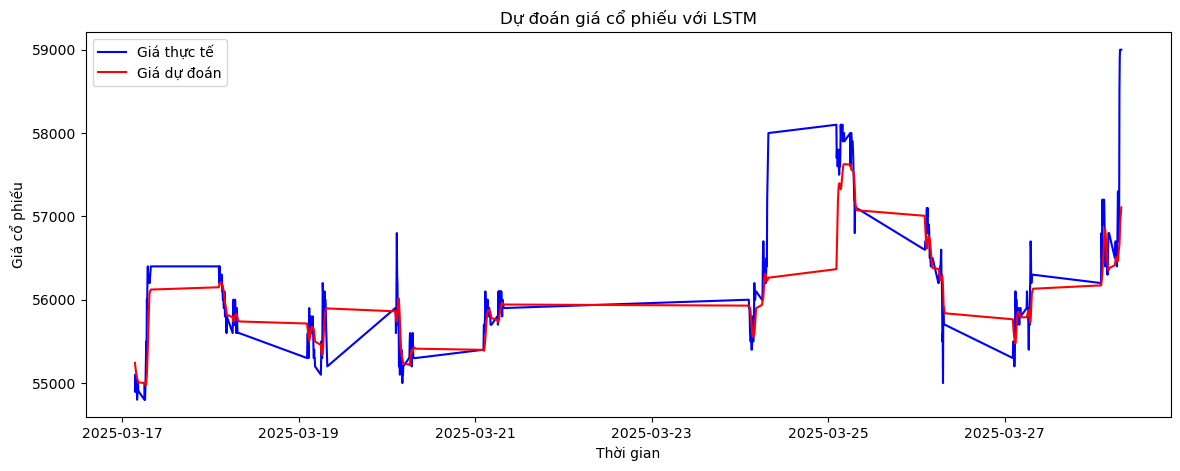

In [17]:
# Dự đoán trên tập kiểm tra
y_pred = model.predict(X_test)

# Đưa dữ liệu dự đoán và thực tế về giá trị gốc
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size + time_step:], y_test_inv, color='blue', label='Giá thực tế')
plt.plot(data.index[train_size + time_step:], y_pred_inv, color='red', label='Giá dự đoán')
plt.title('Dự đoán giá cổ phiếu với LSTM')
plt.xlabel('Thời gian')
plt.ylabel('Giá cổ phiếu')
plt.legend()
plt.show()


In [19]:
# Giả sử 'model' là mô hình LSTM đã được huấn luyện
model.save('BSI.keras')
